# Generate pileup data for ATLAS using a GAN (Generative Adversarial Network)

In [1]:
#imports
import numpy as np
import pandas as pd
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.image import decode_jpeg
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
import os
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.gridspec as gridspec
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
from matplotlib.colors import LogNorm
from atlasgan import reco
from atlasgan import keras_gan as gan

Using TensorFlow backend.


## Only have to run these cell once, then just skip over it and load next cell every other time

In [2]:
#TODO: Implement Wahid's normalization suggestion

#normalization_constant = 487

# #load in the data
# local_path = os.getcwd()
# file_path = "/towahid/mu20_normalized_train.npy"
# data_path = local_path + file_path
# data_full = np.load(data_path)

# jets_full = reco.reconstruct_events(data
# export_csv = jets_full.to_csv(r'/home/wyattblair/working_jets.csv', index = None, header = True)
                                    
# for i in range(len(data_full)):
#         for j in range(len(data_full[i])):
#             for k in range(len(data_full[i][j])):
#                 data_full[i][j][k] = data_full[i][j][k] * normalization_constant
                
# np.save("working_normalized_train", data_full)

# --------------------------------------------------------

In [3]:
local_path = os.getcwd()
file_name1 = "/working_normalized_train.npy"
file_name2 = "/working_jets.csv"
data_path = local_path + file_name1
jets_path = local_path + file_name2

data = np.load(data_path)
jets = pd.read_csv(jets_path)

##### Let's plot some of the training data

In [4]:
#Wahid's draw_image function
def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax, ax=ax)
        cbar.set_label('Energy')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

### Plot Individual Events

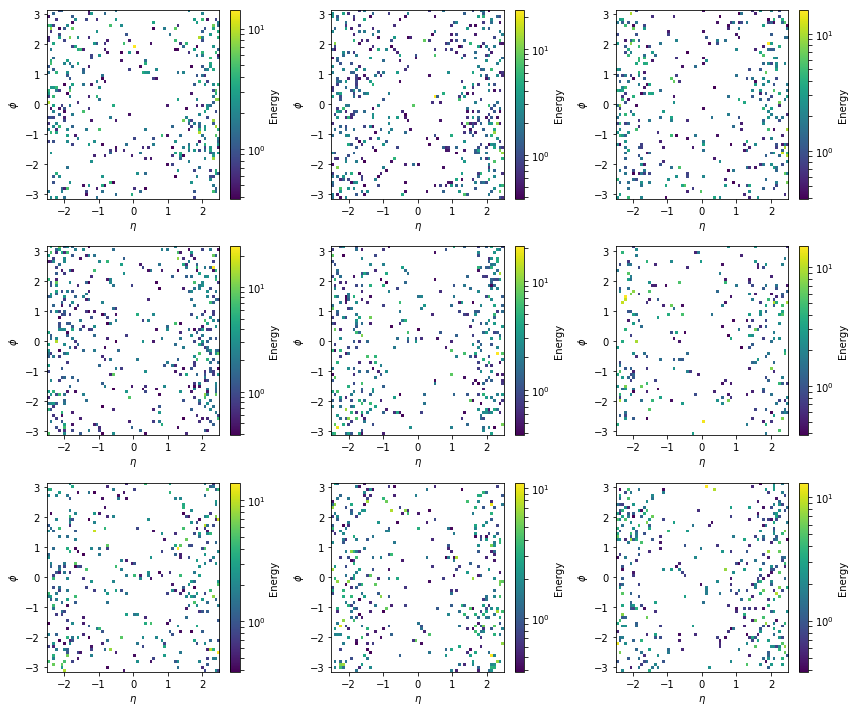

In [5]:
#Populate a list with 9 events from a chosen part of the data set (chosen via sample_seed)
sample_seed = 2
sample_events = []
for i in range(sample_seed, sample_seed+9):
    sample_events.append(data[i])

#Plot the events stored in sample_events using draw_image
fig, axs = plt.subplots(3,3, figsize=(12,10))
for i,ax in enumerate(axs.flatten()):
    draw_image(sample_events[i], ax=ax)
plt.tight_layout()

### Plot the properties of the jets

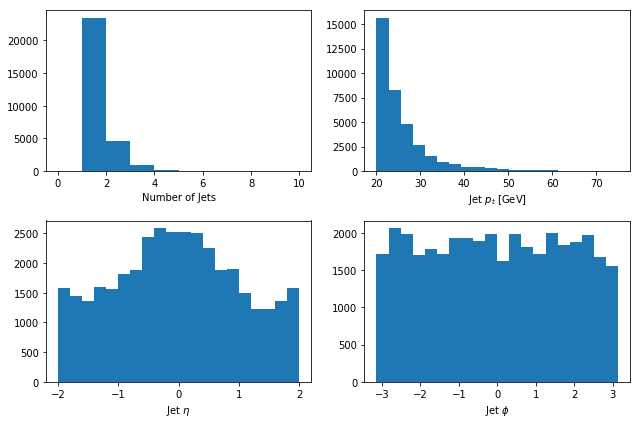

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,6))

#number of jets
jetCount = jets.groupby('event').size()
ax1.hist(jetCount, bins=10, range=(0,10))
ax1.set_xlabel('Number of Jets')

#jet pt
ax2.hist(jets.pt, bins=20, range=(20,75))
ax2.set_xlabel('Jet $p_t$ [GeV]')

#jet eta
ax3.hist(jets.eta, bins= 20, range=(-2,2))
ax3.set_xlabel('Jet $\eta$')

#jet phi
ax4.hist(jets.phi, bins= 20, range= (-np.pi, np.pi))
ax4.set_xlabel('Jet $\phi$')

plt.tight_layout()


<Figure size 432x288 with 0 Axes>

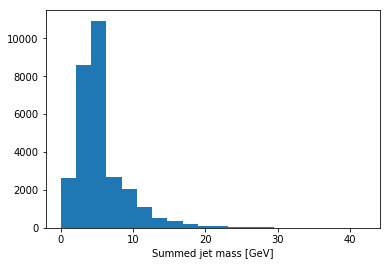

<Figure size 432x288 with 0 Axes>

In [7]:
# Sum of jet mass
sumMass = jets.groupby('event').apply(lambda x: x.m.sum())
plt.hist(sumMass, bins=20)
plt.xlabel('Summed jet mass [GeV]');

plt.figure()

## Let's start training the model

In [8]:
Model = gan.GAN(data)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,229,249
Trainable params: 2,229,249
Non-trainable para

ValueError: total size of new array must be unchanged

In [ ]:
Model.train(epochs = 500)

# normalize after this^

In [ ]:
noise = np.random.normal(0, 1, (len(data), Model.latent_dim))
gen_imgs = Model.generator.predict(noise)

In [ ]:
gen_jets = reco.reconstruct_events(gen_imgs)

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,6))

#number of jets
gen_jetCount = gen_jets.groupby('event').size()
count, binning, patches = ax1.hist(gen_jetCount, label = "fake", bins=10, range=(0,10), alpha = 0.2)
ax1.hist(jetCount, label = "real", bins=binning, alpha = 0.2)
ax1.legend(loc=0)
ax1.set_xlabel('Number of Jets')
print(sum(jetCount), sum(gen_jetCount))
#jet pt
ax2.hist(gen_jets.pt, label="fake", bins=20, range=(20,75), normed = True)
ax2.hist(jets.pt, label="real", bins=20, range=(20,75), normed = True)
ax2.legend(loc=0)
ax2.set_xlabel('Jet $p_t$ [GeV]')

#jet eta
ax3.hist(gen_jets.eta, label="fake", bins= 20, range=(-2,2))
ax3.hist(jets.eta, label="real", bins=20, range=(-2,2))
ax3.legend(loc=0)
ax3.set_xlabel('Jet $\eta$')

print(sum(gen_jets.eta))

#jet phi
ax4.hist(gen_jets.phi, label = "fake", bins= 20, range= (-np.pi, np.pi))
ax4.hist(jets.phi, label="real", bins=20, range= (-np.pi, np.pi))
ax4.legend(loc=0)
ax4.set_xlabel('Jet $\phi$')

plt.tight_layout()

In [ ]:
# Sum of jet mass
gen_sumMass = gen_jets.groupby('event').apply(lambda x: x.m.sum())
plt.hist(gen_sumMass, label ="fake", bins=20)
plt.hist(sumMass, label="real",bins=20)
plt.xlabel('Summed jet mass [GeV]');
plt.legend(loc=0)

plt.figure()